In [11]:
import stir
import stirextra as se
import numpy as np
import matplotlib.pyplot as plt

Generate a 3D mask and interfile header

In [67]:
xv, yv, zv = np.meshgrid(np.linspace(-1,1,128), np.linspace(-1,1,128), np.linspace(-1,1,128))
mask = (xv**2 + zv**2 < 0.5**2) * (yv<0.5) * (yv>-0.5)

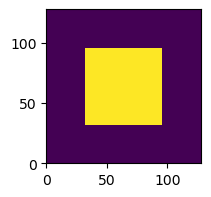

In [68]:
plt.figure(figsize=(2,2))
plt.pcolormesh(mask[:,:,60])

Save to binary file of appropriate format
* header file `f.hv` specifies 4 bytes so we need to ensure its saved as a 32 *bit* float
* Expects the matrix to be in (z,y,x) order, so we need to transpose before saving

In [69]:
np.transpose(mask, (2,1,0)).astype(np.float32).tofile('f.v')

Then can run the bash script to simulate $g = \mathcal{H} f$



In [70]:
!forward_project g.hs f.hv template_g.hs H.par


INFO: 2D PSF Correction. Parallel geometry

Parameters of SPECT UB matrix: (in cm)
Image grid side row: 128	col: 128	transverse voxel_size: 0.2
Number of slices: 128	slice_thickness: 0.2
Number of bins: 128	bin size: 0.2	axial size: 0.2
Number of angles: 96	Angle increment: 3.75	First angle: 180
Number of subsets: 96
Rotation radii: {15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15}
Minimum weight: 0


INFO: Done estimating size of matrix. Execution (CPU) time 3.98 s 

INFO: Processing view 6 of segment 0

INFO: Processing view 2 of segment 0

INFO: Processing view 1 of segment 0

INFO: Processing view 7 of segment 0

INFO: Processing view 4 of segment 0

I

Can then open up and look at $g$

* Note the order the binary array is stored ($\theta$, $r$, $z$)

In [71]:
g = np.fromfile('g.s', dtype=np.float32).reshape((96,128,128))

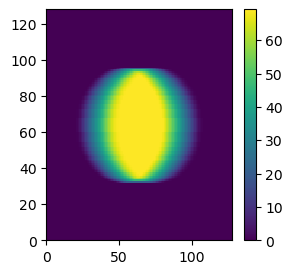

In [73]:
plt.figure(figsize=(3,3))
plt.pcolormesh(g[18])
plt.colorbar()

Now time to reconstruct